# Data Preparation and Inspection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip


Archive:  /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip
  inflating: categories.npy          
  inflating: training_data.npy       
  inflating: valid_periods.npy       


In [ ]:
import numpy as np

categories = np.load('categories.npy')
training_data = np.load('training_data.npy').astype(np.float32)
#valid_periods = np.load('valid_periods.npy')

categories.shape , training_data.shape

((48000,), (48000, 2776))

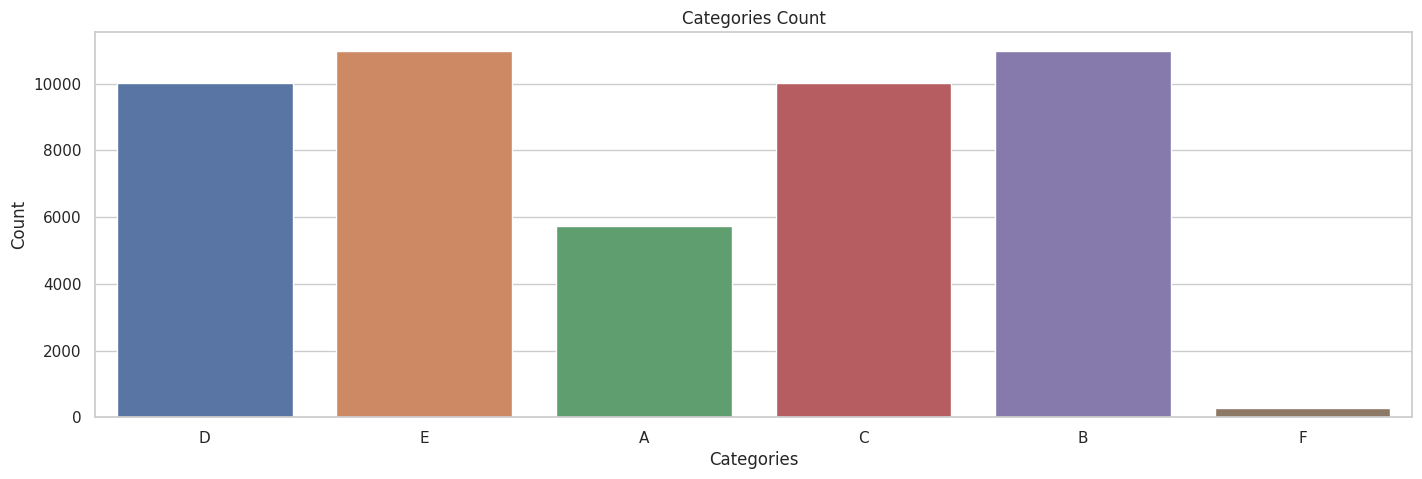

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(17,5))
sns.set(style="whitegrid")
sns.countplot(x=categories)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title('Categories Count')
plt.show()

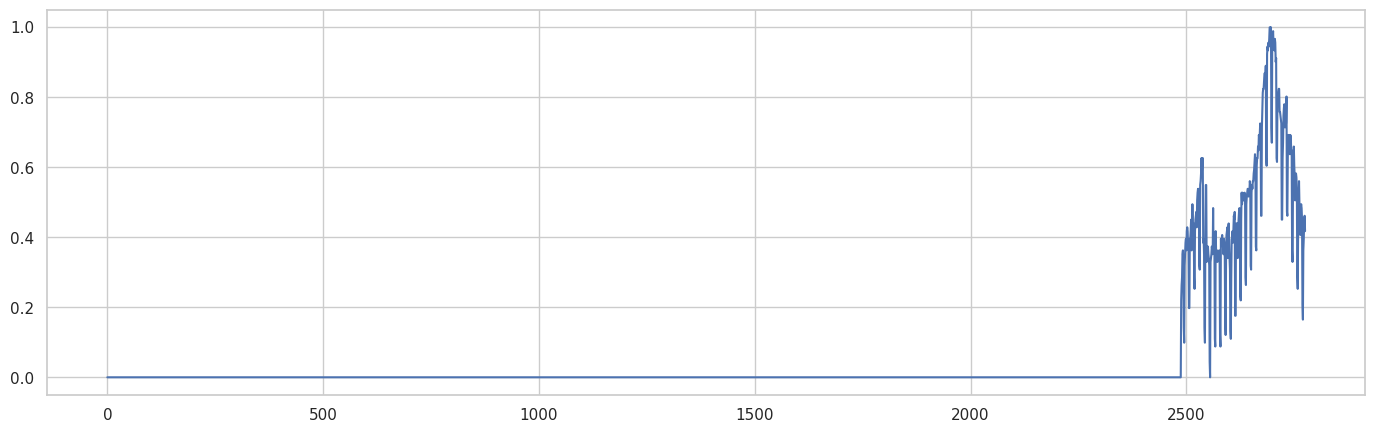

In [ ]:
plt.figure(figsize=(17,5))
#plt.plot(np.concatenate([training_data[i] for i in range(50)], axis=0))
plt.plot(training_data[1000])
plt.show()

In [ ]:
All_timeserieses = {key: [] for key in np.unique(categories)}
Next_series_idx = {key: [0] for key in np.unique(categories)}

for cat in np.unique(categories):
  timeseries = training_data[categories == cat]
  for i in range (len(timeseries)):
    tmp = timeseries[i][np.argmax(timeseries[i]> 0):]
    All_timeserieses[cat].append(tmp)
    Next_series_idx[cat].append(Next_series_idx[cat][-1]+len(tmp))

  All_timeserieses[cat] =  np.concatenate([arr.flatten() for arr in All_timeserieses[cat]])

  print (f"The category : {cat} has lenght of :{len(All_timeserieses[cat])} ")




The category : A has lenght of :1592528 
The category : B has lenght of :1819914 
The category : C has lenght of :2081585 
The category : D has lenght of :2171479 
The category : E has lenght of :1787949 
The category : F has lenght of :53835 


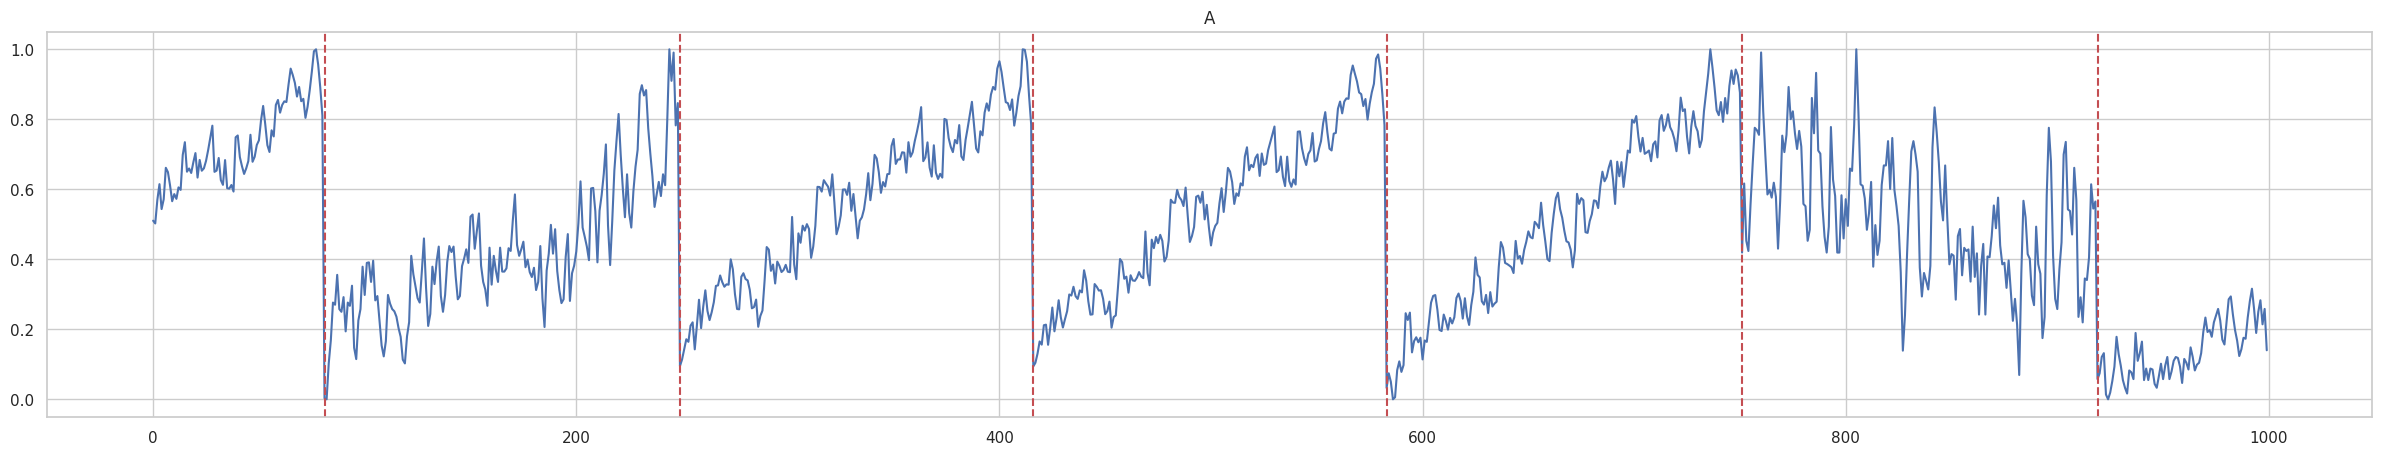

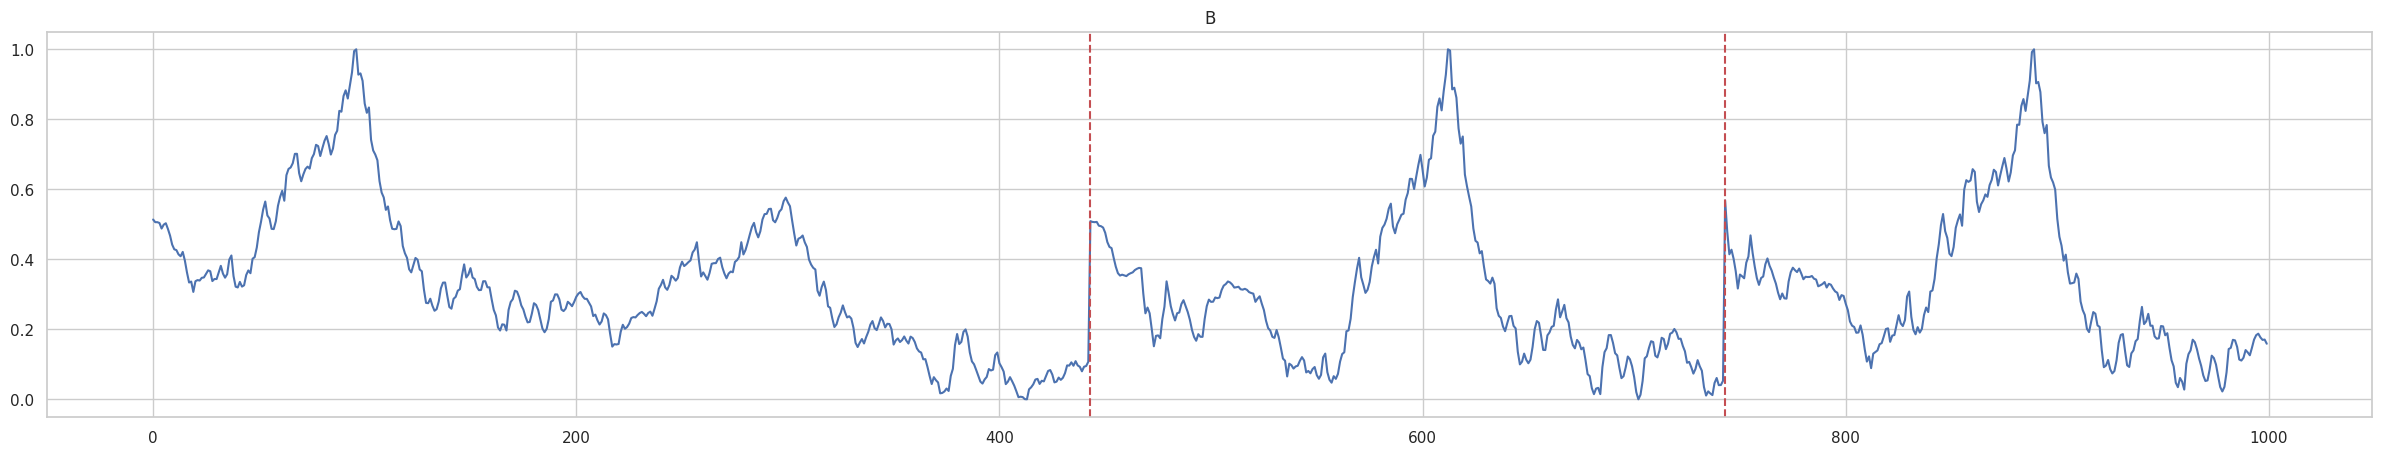

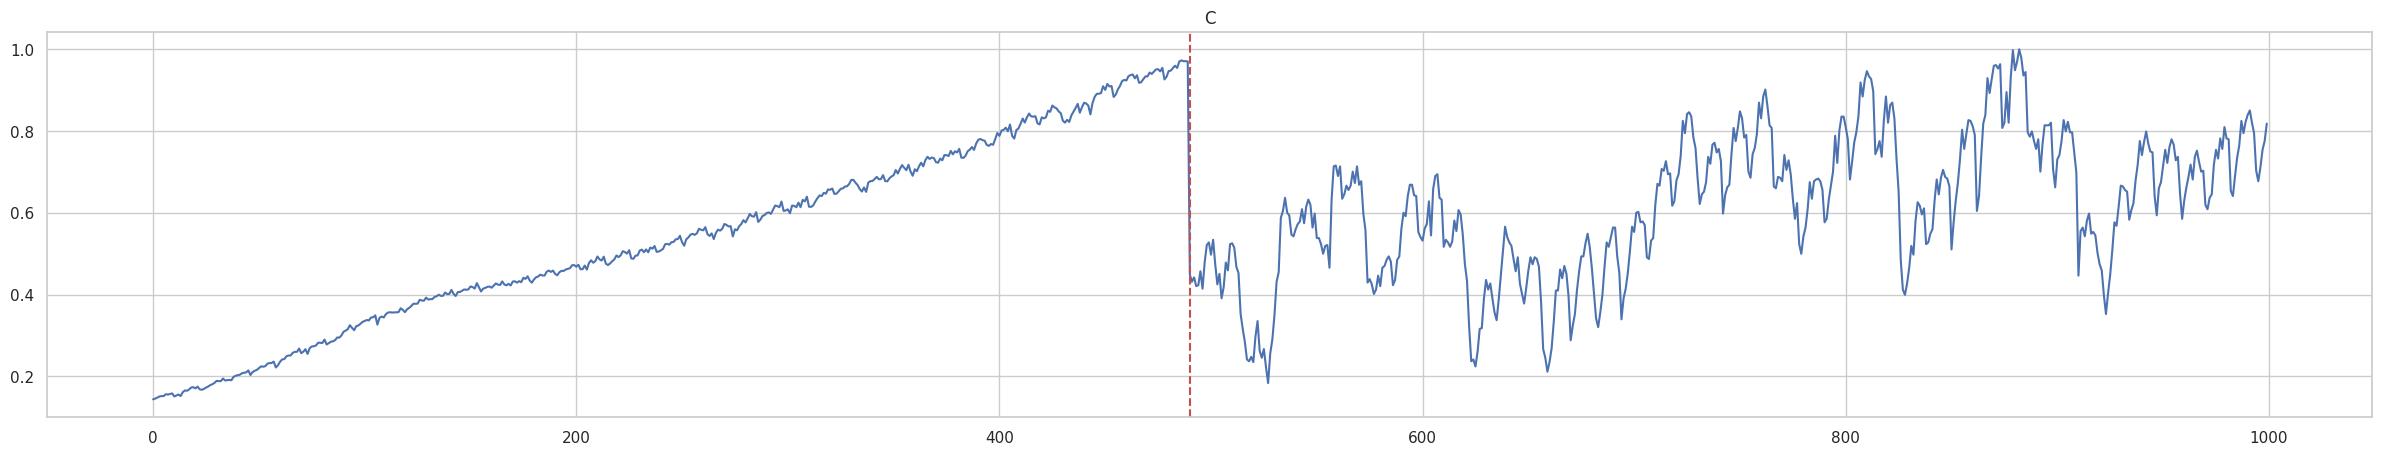

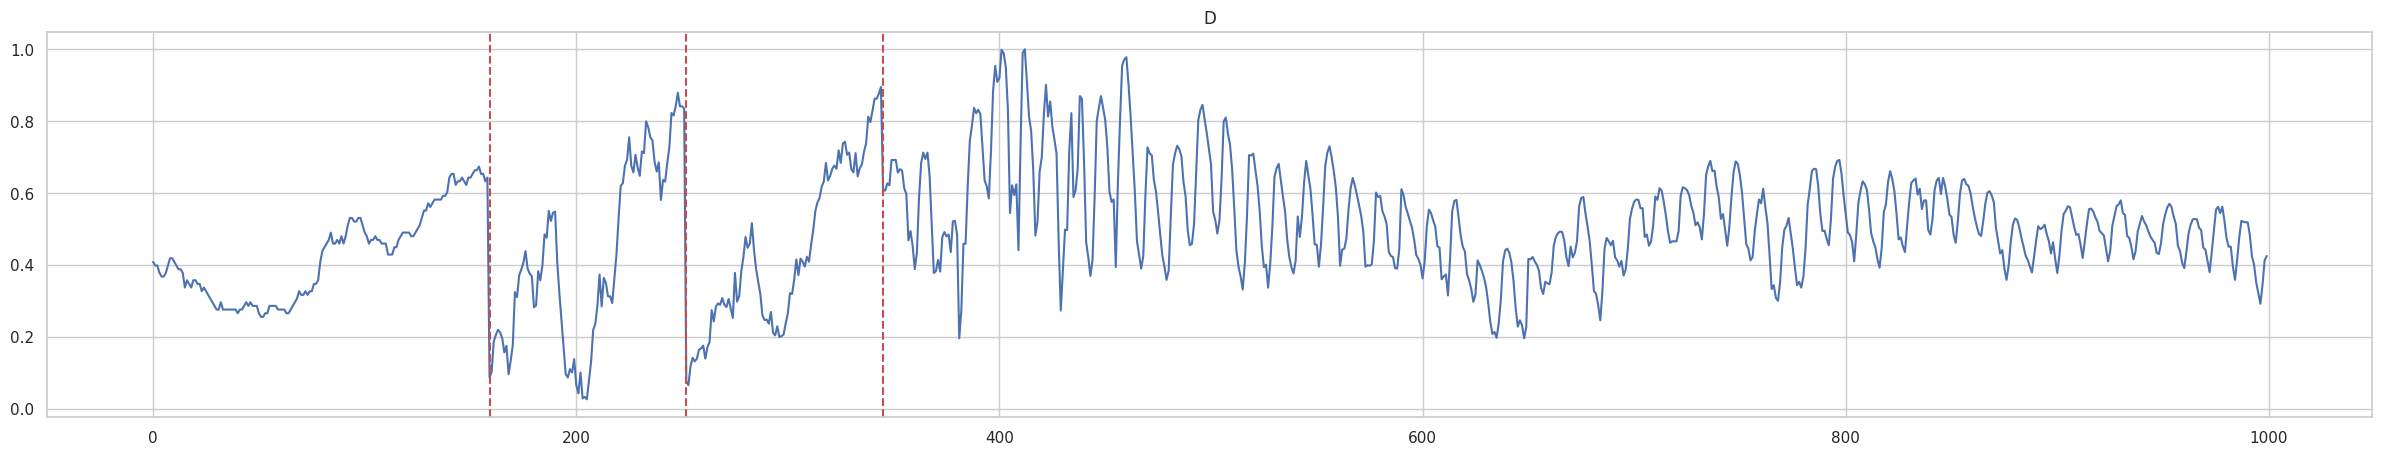

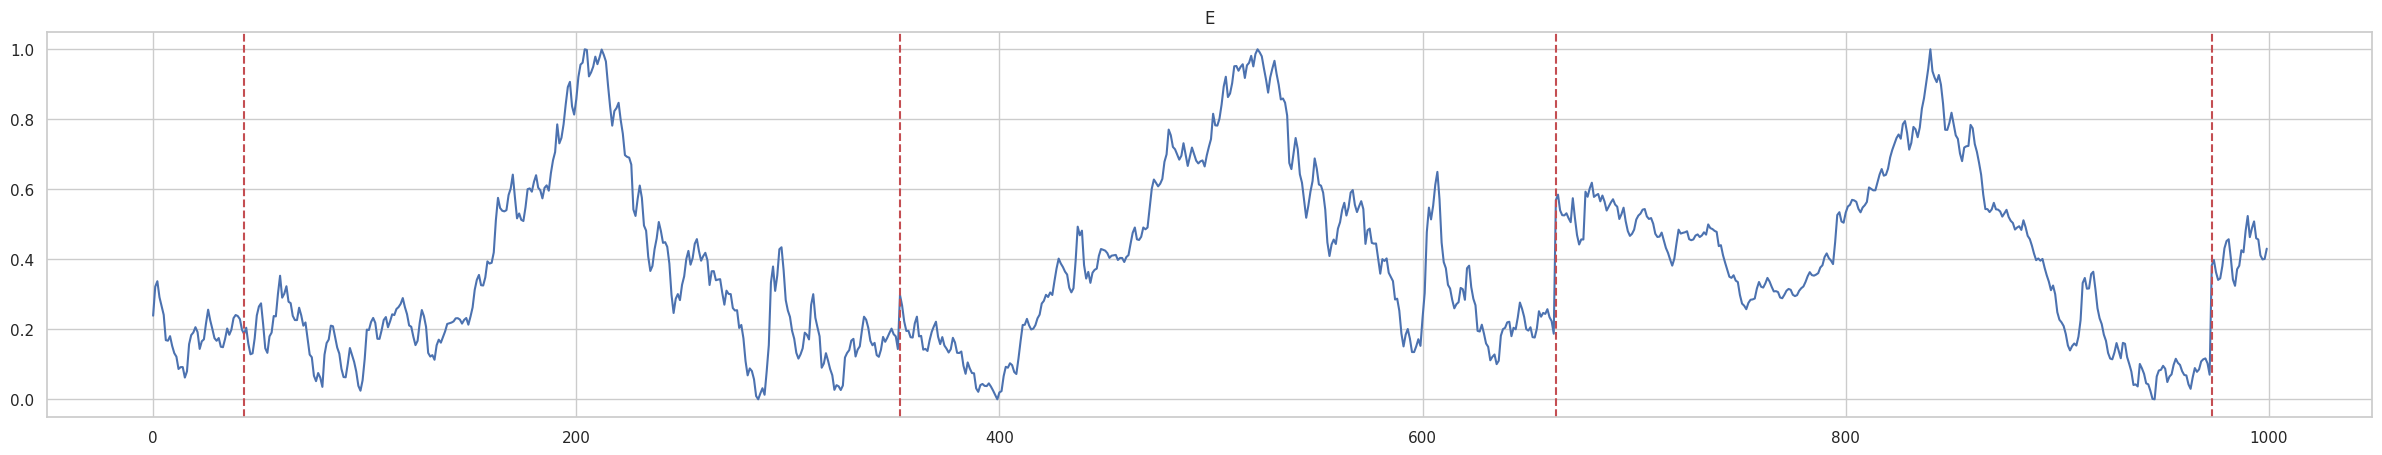

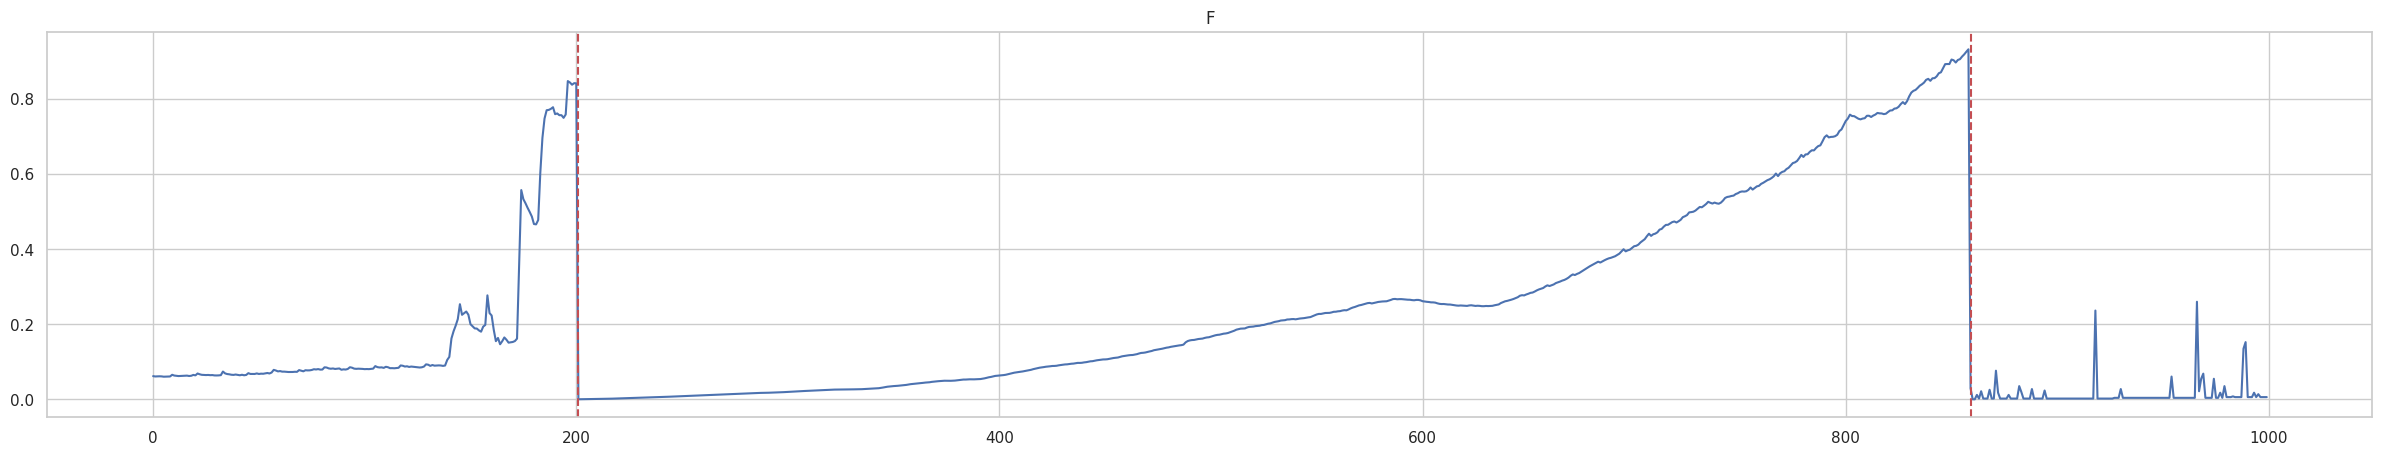

In [ ]:
# Plot all time series
start = 2000
end = 3000
for category in All_timeserieses:
    plt.figure(figsize=(30,5))
    plt.plot(All_timeserieses[category][start:end])
    idx = [element - start for element in Next_series_idx[category] if start <=element < end]
    for i in idx:
      plt.axvline( x = i , color = 'r',  linestyle='--')
    plt.title(category)
    plt.show()


In [ ]:
del categories
del training_data
del timeseries

In [ ]:
#Train Test Split and normalize

test_size = 3000

Train_dict = {}
Test_dict = {}

for key in All_timeserieses:
  value = All_timeserieses[key]
  Train_dict[key] = value[:-test_size]
  Test_dict[key] = value[-test_size:]

  # min = Train_dict[key].min()
  # max = Train_dict[key].max()

  # Train_dict[key] = (Train_dict[key] - min) / (max - min)
  # Test_dict[key] = (Test_dict[key] - min ) / (max - min)




In [ ]:
def Gen_dataset(data_dict, window = 200 , stride = 25 , telescope = 9):
  X = []
  labels = []
  category = []

  for cat in data_dict:

    temp_data = data_dict[cat]
    padding_check = len(temp_data) % window

    if (padding_check !=0):
      padding_len = window - len(temp_data)%window
      padding = np.zeros((padding_len), dtype='float32')
      temp_data = np.concatenate((padding,temp_data))

    for idx in np.arange(0,len(temp_data)-window-telescope,stride):
      X.append(temp_data[idx:idx+window])
      labels.append(temp_data[idx+window:idx+window+telescope])
      category.append(cat)

  return np.array(X), np.array(labels), np.array(category)

In [ ]:
X_train, Y_train , Cat_train = Gen_dataset(Train_dict)

In [ ]:
X_train = X_train[:, :, np.newaxis]
Y_train = Y_train[:, :, np.newaxis]
Cat_train = Cat_train[:, np.newaxis]

In [ ]:
X_train.shape , Y_train.shape, Cat_train.shape

((379544, 200, 1), (379544, 9, 1), (379544, 1))

In [ ]:
X_test, Y_test, Cat_test = Gen_dataset(Test_dict)

In [ ]:
X_test = X_test[:, :, np.newaxis]
Y_test = Y_test[:, :, np.newaxis]
Cat_test = Cat_test[:, np.newaxis]

In [ ]:
X_test.shape , Y_test.shape , Cat_test.shape

((672, 200, 1), (672, 9, 1), (672, 1))

In [ ]:
del All_timeserieses
del Train_dict
del Test_dict
del value

# Building, Training, and Diagnosing a Model

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Create a mapping from unique categories to integer labels
def One_hot_encoding(category_array):
  unique_categories = np.unique(category_array)
  category_to_index = {category: index for index, category in enumerate(unique_categories)}

  # Convert string categories to integer labels
  integer_labels = np.array([category_to_index[category] for category in category_array])

  # Convert integer labels to one-hot encoded categorical variable
  return tf.keras.utils.to_categorical(integer_labels)
Cat_test = One_hot_encoding(Cat_test[:,0])
Cat_train = One_hot_encoding(Cat_train[:,0])

In [ ]:
Cat_train = Cat_train[:, :, np.newaxis]
Cat_test = Cat_test[: , :, np.newaxis]
Cat_train.shape , Cat_test.shape

((379544, 6, 1), (672, 6, 1))

In [ ]:
def Model_V_1(input_shape , output_shape, Cat_shape):

  input1 = tfkl.Input(shape = input_shape , name = 'input_time_series')
  input2 = tfkl.Input(shape = Cat_shape , name = 'domain_label_input')

  # Add a Bidirectional LSTM layer with 64 units
  x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input1)

  # Add a 1D Convolution layer with 128 filters and a kernel size of 3
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

  # Add a final Convolution layer to match the desired output shape
  x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

  # Calculate the size to crop from the output to match the output shape
  # Crop the output to the desired length

  x = tfkl.Concatenate(axis = -2)([x, input2])

  x = tfkl.Dense(1, activation = 'sigmoid')(x)

  crop_size = x.shape[1] - output_shape[0]
  output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(x)


  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=[input1, input2] , outputs=output_layer, name='CONV_LSTM_model')

  # Compile the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), run_eagerly=True)

  return model


In [ ]:
def Model_V_2(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), run_eagerly=True)

    return model

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_time_series (InputLa  [(None, 200, 1)]             0         []                            
 yer)                                                                                             
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_time_series[0][0]']   
 ctional)                                                                                         
                                                                                                  
 conv (Conv1D)               (None, 200, 128)             49280     ['bidirectional_lstm[0][0]']  
                                                                                    

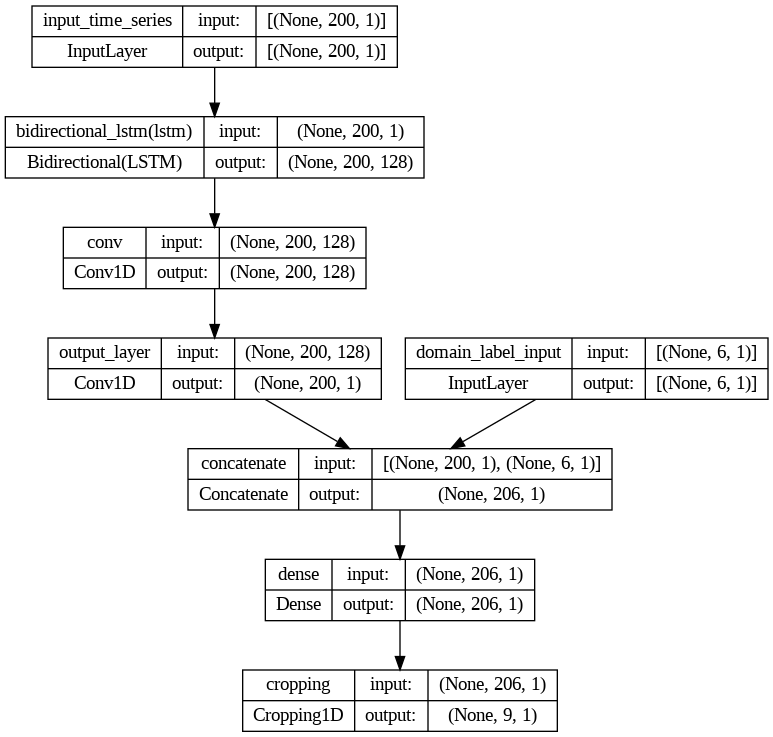

In [ ]:
model = Model_V_1(X_train.shape[1:], Y_train.shape[1:], Cat_train.shape[1:])
#model = Model_V_1(X_train.shape[1:], Y_train.shape[1:])
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
#train_dataset = tf.data.Dataset.from_tensor_slices(([X_train, Cat_train[:,:,np.newaxis]], Y_train)).batch(64)
history = model.fit(
    x = [X_train, Cat_train],
    y = Y_train,
    batch_size = 128,
    epochs = 20,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/20
2669/2669 [==============================] - 198s 70ms/step - loss: 0.0717 - val_loss: 0.0757 - lr: 0.0010
Epoch 2/20
2669/2669 [==============================] - 185s 69ms/step - loss: 0.0559 - val_loss: 0.0750 - lr: 0.0010
Epoch 3/20
2669/2669 [==============================] - 182s 68ms/step - loss: 0.0719 - val_loss: 0.0757 - lr: 0.0010
Epoch 4/20
2669/2669 [==============================] - 184s 69ms/step - loss: 0.0717 - val_loss: 0.0767 - lr: 0.0010
Epoch 5/20
2669/2669 [==============================] - 187s 70ms/step - loss: 0.0716 - val_loss: 0.0766 - lr: 0.0010
Epoch 6/20
2669/2669 [==============================] - 183s 68ms/step - loss: 0.0715 - val_loss: 0.0760 - lr: 1.0000e-04
Epoch 7/20
2669/2669 [==============================] - 191s 71ms/step - loss: 0.0469 - val_loss: 0.0291 - lr: 1.0000e-04
Epoch 8/20
2669/2669 [==============================] - 186s 70ms/step - loss: 0.0195 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 9/20
2669/2669 [======================

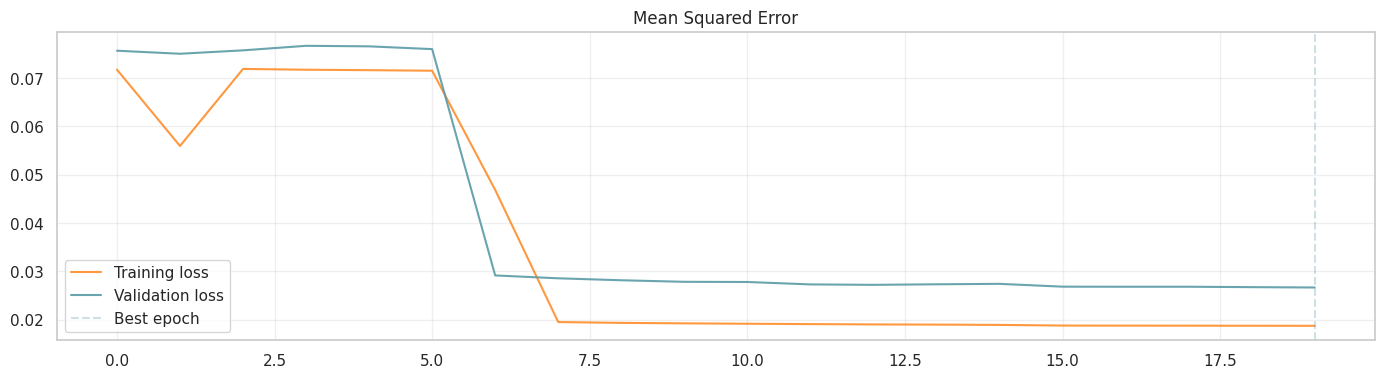

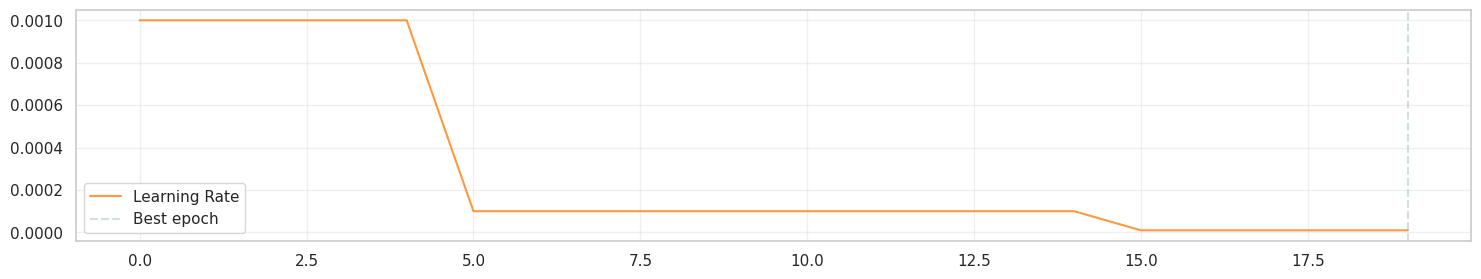

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/AN2DL_HW_2/V_1_9_Dec")